### Configuration

In [66]:
source_dir = './texts'
chap_pat=r'(^\n*(?:CHAPTER \d+).*$)|(^\n*(?:Chapter \d+).*$)|(^\n*(?:Chapter ((?=[MDCLXVI])M*D?C{0,4}L?X{0,4}V?I{0,4})).*$)|(^\n*(?:CHAPTER ((?=[MDCLXVI])M*D?C{0,4}L?X{0,4}V?I{0,4})).*$)|(^\n*(?:Footnote).*$)|\
            (^\n*(?:INTRODUCTION).*$)|(^\n*(?:PART ((?=[MDCLXVI])M*D?C{0,4}L?X{0,4}V?I{0,4})).*$)|(^\s*(?:CHAPTER \d+).*$)|(^\s*(?:Chapter \d+).*$)|(^\s*(?:Chapter ((?=[MDCLXVI])M*D?C{0,4}L?X{0,4}V?I{0,4})).*$)|\
            (^\n*(?:CHAPTER ((?=[MDCLXVI])M*D?C{0,4}L?X{0,4}V?I{0,4})).*$)|(^\n*(?:Footnote).*$)|\
            (^\s*(?:INTRODUCTION).*$)|(^\s*(?:PART ((?=[MDCLXVI])M*D?C{0,4}L?X{0,4}V?I{0,4})).*$)'
para_pat = r'\n\n+'
token_pat = r'([\W_]+)'
db_file = 'novels.db'

In [2]:
extra_stopwords = """
us rest went least would much must long one like much say well without though yet might still upon
done every rather particular made many previous always never thy thou go first oh thee ere ye came
almost could may sometimes seem called among another also however nevertheless even way one two three
ever put therefore whose
""".strip().split()

### Functions

In [273]:
   
def analyze_sentiment_vader_lexion(book, 
                                    threshold=0.1,
                                    verbose=False):
        # analyze the sentiment for chapter
        analyzer = SentimentIntensityAnalyzer()
        scores = analyzer.polarity_scores(book)
        # get aggregate scores and final sentiment
        agg_score = scores['compound']
        final_sentiment = 'positive' if agg_score >= threshold\
                                   else 'negative'
        if verbose:
            # display detailed sentiment statistics
            positive = str(round(scores['pos'], 2)*100)+'%'
            final = round(agg_score, 2)
            negative = str(round(scores['neg'], 2)*100)+'%'
            neutral = str(round(scores['neu'], 2)*100)+'%'
        return final_sentiment, final,positive,negative,neutral     

    
def genearte_book_sentiment(books):
    final_sens=[]
    finals=[]
    pos=[]
    neg=[]
    neu=[]
    book_nums=[]
    for book,book_num in zip(books,books.index.tolist()):
        final_sentiment, final,positive,negative,neutral=analyze_sentiment_vader_lexion(book,threshold=0.4,verbose=True)
        final_sens.append(final_sentiment)
        finals.append(final)
        pos.append(positive)
        neg.append(negative)
        neu.append(neutral)
        book_nums.append(book_num)
    sentiment_frame = pd.DataFrame({'Predicted Sentiment':final_sens, 'Polarity Score':finals, 'Positive':pos,
                                        'Negative':neg, 'Neutral':neu,'book_num':book_nums})
    return sentiment_frame



### Libraries

In [275]:
import glob
import sqlite3
import random
import pandas as pd
import numpy as np
import re
from IPython.display import display, HTML
from nltk.sentiment.vader import SentimentIntensityAnalyzer


import nltk
from nltk.tokenize import RegexpTokenizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('tagsets')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/nh4mq/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nh4mq/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/nh4mq/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to /home/nh4mq/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nh4mq/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


True

### Pragmas

In [5]:
%matplotlib inline

### Import files

In [6]:
files = glob.glob("{}/*.txt".format(source_dir))

In [7]:
len(files)

439

### Only Analyze 100 Books (Randomly Select)

In [9]:
random.seed(42)
rand=random.sample(range(439), 100)

In [10]:
print(rand)

[327, 57, 12, 379, 140, 125, 114, 71, 377, 52, 346, 435, 279, 44, 302, 216, 16, 15, 47, 111, 119, 258, 308, 13, 287, 101, 366, 332, 359, 426, 214, 112, 229, 301, 142, 3, 388, 81, 357, 423, 174, 404, 79, 110, 390, 172, 429, 420, 194, 49, 183, 176, 309, 135, 22, 373, 235, 274, 63, 193, 40, 282, 150, 321, 316, 185, 295, 98, 360, 35, 23, 338, 116, 148, 378, 418, 51, 394, 397, 232, 325, 186, 83, 189, 181, 107, 343, 136, 349, 331, 36, 311, 358, 87, 273, 433, 356, 236, 361, 138]


In [12]:
final_files=[]
for i in rand:
    final_files.append(files[i])

In [13]:
len(final_files)

100

### Process Files

In [20]:
novel_info=pd.read_csv("cenlab-index.csv")

In [26]:
novel_info.head(1)

,Unnamed: 0,author,date,filename,gender,nationality,title,words,modernist
0,0,Frances Burnett,1881,1881 a fair barbarian.txt,f,a,A Fair Barbarian,41718.0,n


In [19]:
#Using cenlab-index file to get author information
#attache the information to the content dataframe.
keys=[x.replace('./texts/','') for x in final_files]

In [278]:
T=pd.DataFrame(keys,columns=["filename"])

In [279]:
T=T.merge(novel_info[["filename","date","gender","author","nationality","title","words"]],how="left",on="filename")

In [280]:
T['text'] = [open(f, 'r', encoding='utf-8').read() for f in final_files]

In [32]:
T.head(1)

,filename,date,gender,nationality,title,words,text
0,1903 the heart of rome.txt,1903,m,a,The Heart of Rome,99632.0,\n\n\n\nTHE HEART OF ROME\n\n\n\n\n\n\nCHAPTER...


In [42]:
#Keep less clumns for OHCO purpus
OHCO_T=T.copy() 

In [43]:
OHCO_T=OHCO_T[["gender","nationality","date","title","text"]]

### Create stopwords list

In [40]:
sw = nltk.corpus.stopwords.words('english') + extra_stopwords

### Fix some characters to improve tokenization

In [44]:
OHCO_T.text = OHCO_T.text.str.replace(r"(—|-)", ' \g<1> ')

In [45]:
OHCO_T.head(1)

,gender,nationality,date,title,text
0,m,a,1903,The Heart of Rome,\n\n\n\nTHE HEART OF ROME\n\n\n\n\n\n\nCHAPTER...


### Text to Chapters

In [64]:
chaps= OHCO_T.text.str.split(chap_pat, expand=True)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'chap_str'})

In [67]:
OHCO = ['book_num','chap_num', 'para_num', 'sent_num', 'token_num']
BOOKS = OHCO[:1]
CHAPS = OHCO[:2]
PARAS = OHCO[:3]
SENTS = OHCO[:4]

In [68]:
chaps.index.names=CHAPS
chaps.chap_str = chaps.chap_str.str.strip()
chaps.chap_str = chaps.chap_str.str.replace(r'(\n*Chapter)|(\n*CHAPTER)|(\n*Footnote)|(\n*INTRODUCTION)', ' ')
chaps=chaps[~chaps.chap_str.str.match(r'^\s*$')]
chaps = (chaps.groupby(chaps.index.get_level_values('book_num'))
          .apply(lambda x: x.reset_index()).drop(['book_num','chap_num'],1))
chaps.index = chaps.index.rename(['book_num','chap_num'])
    

In [70]:
chaps.head()

,,chap_str
book_num,chap_num,
0,0,THE HEART OF ROME I\n\n\n\n\nThe Baroness Vol...
1,0,THE LOG OF A COWBOY I\n\nUP THE TRAIL\n\nJust...
2,0,SPRING DAYS\n\nBY GEORGE MOORE\n\n\n\n\nPREFAC...
3,0,MUSLIN\n\n\n\nI\n\n\nThe convent was situated ...
4,0,1\n\nJonathan Harker's Journal\n\n(Kept in s...


### Chapters to Paragraphs

In [72]:
paras = chaps.chap_str.str.split(para_pat, expand=True)\
    .stack()\
    .to_frame()\
    .rename(columns={0:'para_str'})
paras.index.names = PARAS
paras.para_str = paras.para_str.str.strip()
paras.para_str = paras.para_str.str.replace(r'\n', ' ')
paras.para_str = paras.para_str.str.replace(r'\s+', ' ')
paras = paras[~paras.para_str.str.match(r'^\s*$')]

In [74]:
paras.head()

para_str
book_num chap_num para_num                                                   
0        0        0                                       THE HEART OF ROME I
                  1         The Baroness Volterra drove to the Palazzo Con...
                  2         The big porter of the palace was sweeping the ...
                  3         He did not even lift his cap to her, yet there...
                  4         The Baroness was rather more exigent in requir...

### Paragraphs to Sentences

In [75]:
sents = paras.para_str\
    .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
    .stack()\
    .to_frame()\
    .rename(columns={0:'sent_str'})
sents.index.names = SENTS
del(paras)

In [76]:
sents.head()

sent_str
book_num chap_num para_num sent_num                                                   
0        0        0        0                                       THE HEART OF ROME I
                  1        0         The Baroness Volterra drove to the Palazzo Con...
                           1         She had tried twice to telephone, on the previ...
                           2         She was very anxious to see Clementina at once...
                           3         She only wanted the name, and expected nothing...

### Sentences to Tokens with POS tagging

In [77]:
tokenizer = RegexpTokenizer('\s+', gaps=True)

In [78]:
tokens = sents.sent_str\
    .apply(lambda x: pd.Series(nltk.pos_tag(tokenizer.tokenize(x))))\
    .stack()\
    .to_frame()\
    .rename(columns={0:'pos_tuple'})
tokens.index.names = OHCO
tokens['pos'] = tokens.pos_tuple.apply(lambda x: x[1])
tokens['token_str'] = tokens.pos_tuple.apply(lambda x: x[0])
tokens = tokens.drop('pos_tuple', 1)
del(sents)

In [79]:
tokens.head()

pos token_str
book_num chap_num para_num sent_num token_num               
0        0        0        0        0           DT       THE
                                    1          NNP     HEART
                                    2          NNP        OF
                                    3          NNP      ROME
                                    4          PRP         I

### Tag punctuation and numbers

In [80]:
tokens['punc'] = tokens.token_str.str.match(r'^[\W_]*$').astype('int')
tokens['num'] = tokens.token_str.str.match(r'^.*\d.*$').astype('int')

### Extract vocab with minimal normalization

In [81]:
WORDS = (tokens.punc == 0) & (tokens.num == 0)
tokens.loc[WORDS, 'term_str'] = tokens.token_str.str.lower()\
    .str.replace(token_pat, '')
#     .str.replace(r'["_*.\']', '')
vocab = tokens[tokens.punc == 0].term_str.value_counts().to_frame()\
    .reset_index()\
    .rename(columns={'index':'term_str', 'term_str':'n'})
vocab = vocab.sort_values('term_str').reset_index(drop=True)
vocab.index.name = 'term_id'

### Get priors for Vocab

In [82]:
vocab['p'] = vocab.n / vocab.n.sum()

### Add stems

In [83]:
stemmer = nltk.stem.porter.PorterStemmer()
vocab['port_stem'] = vocab.term_str.apply(lambda x: stemmer.stem(x))

### Define stopwords

In [84]:
stopwords = set(nltk.corpus.stopwords.words('english') + extra_stopwords)

In [85]:
sw = pd.DataFrame({'x':1}, index=stopwords)
vocab['stop'] = vocab.term_str.map(sw.x).fillna(0).astype('int')
del(sw)

### Add term_ids to Tokens

In [86]:
tokens['term_id'] = tokens['term_str'].map(vocab.reset_index()\
    .set_index('term_str').term_id).fillna(-1).astype('int')

### Save

In [87]:
with sqlite3.connect(db_file) as db:
    OHCO_T.to_sql('doc', db, if_exists='replace', index=True)
    tokens.to_sql('token', db, if_exists='replace', index=True)
    vocab.to_sql('vocab', db, if_exists='replace', index=True)

### Create DTM

In [88]:
docs=OHCO_T

#### Create word mask

In [89]:
WORDS = (tokens.punc == 0) & (tokens.num == 0)

### Extrct BOW from tokens

In [91]:
BAG = CHAPS

In [92]:
BOW = tokens[WORDS].groupby(BAG + ['term_id'])['term_id'].count()

In [93]:
BOW.head()

book_num  chap_num  term_id
0         0         0          2051
                    14            1
                    15            1
                    91            1
                    112          23
Name: term_id, dtype: int64

### Convert BOW to DTM

In [94]:
DTM = BOW.unstack().fillna(0)

In [95]:
DTM.head()

,term_id,0,1,2,3,4,5,6,7,8,9,...,64376,64377,64378,64379,64380,64381,64382,64383,64384,64385
book_num,chap_num,,,,,,,,,,,,,,,,,,,,,
0,0,2051.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,2502.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2090.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1970.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,2941.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Create Bags table

In [96]:
bags = pd.DataFrame(index = DTM.index)
bags['term_count'] = DTM.sum(1)
bags['tf'] = bags.term_count / bags.term_count.sum()
DTM = DTM.reset_index(drop=True)
DTM.index.name = 'bag_id'

### Computer Term Frequencies and Weights

#### Compute TF 

#### Compute IDF 

In [97]:
N_docs = DTM.shape[0]
vocab['df'] = DTM[DTM > 0].count()
vocab['idf'] = np.log10(N_docs / vocab.df)

### Test: View most frequent non-stops by IDF 

In [98]:
vocab[vocab.stop==0].sort_values('n', ascending=False).head(500)\
    .sort_values('idf', ascending=False).head(20)

,term_str,n,p,port_stem,stop,df,idf
term_id,,,,,,,
8512,carrie,1273,0.000149,carri,0,3,1.522879
8039,cameron,1753,0.000205,cameron,0,3,1.522879
31580,kitty,1435,0.000168,kitti,0,9,1.045757
47899,robert,1401,0.000164,robert,0,20,0.698970
34140,madame,1354,0.000158,madam,0,43,0.366532
57367,tom,1513,0.000177,tom,0,44,0.356547
34930,mary,2246,0.000262,mari,0,50,0.301030
57653,toward,1453,0.000170,toward,0,60,0.221849
3452,aunt,1729,0.000202,aunt,0,62,0.207608


In [99]:
#### Computer TFIDF 
##### TF: term count(I used term frequency)
##### N: number of docs
##### DF: number of docs with term
##### log = log10
##### (1 + log(TF)) * log( N / DF)

In [100]:
TFIDF = DTM * vocab['idf']

In [101]:
TFIDF.head()

term_id,0,1,2,3,4,5,6,7,8,9,...,64376,64377,64378,64379,64380,64381,64382,64383,64384,64385
bag_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.39794,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.568636,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [151]:
TFIDF.shape

(100, 64386)

### Test: Stopwords Detected?

In [109]:
vocab[TFIDF.sum() == 0].head()

,term_str,n,p,port_stem,stop,df,idf,tfidf_sum,tfidf_mean,tfidf_max
term_id,,,,,,,,,,
0,a,185934,0.021717,a,1,100,0.0,0.0,0.0,0.0
159,about,14507,0.001694,about,1,100,0.0,0.0,0.0,0.0
162,above,2151,0.000251,abov,1,100,0.0,0.0,0.0,0.0
969,after,11137,0.001301,after,1,100,0.0,0.0,0.0,0.0
988,again,10548,0.001232,again,1,100,0.0,0.0,0.0,0.0


### Add stats to Vocab

In [103]:
vocab['tfidf_sum'] = TFIDF.sum()
vocab['tfidf_mean'] = TFIDF.mean()
vocab['tfidf_max'] = TFIDF.max()

### Get Top words and Trim Matrix

##### SELECT * 
##### FROM vocab 
##### WHERE stop = 0
##### ORDER BY n DESC
##### LIMIT 1000

In [104]:
def get_top_terms(vocab, no_stops=True, sort_col='n', k=1000):
    if no_stops:
        V = vocab[vocab.stop == 0]
    else:
        V = vocab
    return V.sort_values(sort_col, ascending=False).head(k)

### Remove proper nouns

In [105]:
proper_nouns = tokens.loc[tokens.pos == 'NNP', 'term_id'].unique()

In [106]:
top_n = 1000
# TOPV = get_top_terms(vocab, sort_col='n')
TOPV = get_top_terms(vocab.loc[~vocab.index.isin(proper_nouns)], sort_col='n')

In [108]:
TOPV.head()

,term_str,n,p,port_stem,stop,df,idf,tfidf_sum,tfidf_mean,tfidf_max
term_id,,,,,,,,,,
2999,asked,6451,0.000753,ask,0,99,0.004365,28.157360,0.281574,1.540776
58561,turned,5564,0.000650,turn,0,99,0.004365,24.285777,0.242858,0.689639
24258,going,5485,0.000641,go,0,100,0.000000,0.000000,0.000000,0.000000
13100,cried,4393,0.000513,cri,0,94,0.026872,118.049339,1.180493,12.952375
63027,whole,3264,0.000381,whole,0,100,0.000000,0.000000,0.000000,0.000000


In [114]:
tfidf_small = TFIDF[TOPV.index].stack().to_frame().rename(columns={0:'w'})

In [115]:
tfidf_small.head()

w
bag_id term_id          
0      2999     0.711463
       58561    0.340455
       24258    0.000000
       13100    0.940525
       63027    0.000000

### Save Data

In [111]:
db_name='novels.db'

In [113]:
with sqlite3.connect(db_name) as db:
    vocab.to_sql('vocab', db, if_exists='replace', index=True)
    tokens.to_sql('token', db, if_exists='replace', index=True)
    docs.to_sql('doc', db, if_exists='replace', index=True)

"with sqlite3.connect(db_name) as db:\n    vocab.to_sql('vocab', db, if_exists='replace', index=True)\n    tokens.to_sql('token', db, if_exists='replace', index=True)\n    docs.to_sql('doc', db, if_exists='replace', index=True)"

In [119]:
with sqlite3.connect(db_name) as db:
    tfidf_small.to_sql('tfidf_small', db, if_exists='replace', index=True)
    bags.reset_index().to_sql('bag', db, if_exists='replace', index=True, index_label='bag_id')

# Compare Between Books Using Consine Similarity  

In [219]:
### Libraries 
import pandas as pd
import sqlite3
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [184]:
SIMS = pdist(TFIDF, metric='cosine')
pair_idx = [(i, j) for i in TFIDF.index for j in TFIDF.index if j > i]


In [183]:
doc_pairs=pd.DataFrame(columns=["cosine"],index=pd.MultiIndex.from_tuples(pair_idx))

In [186]:
doc_pairs["cosine"]=SIMS

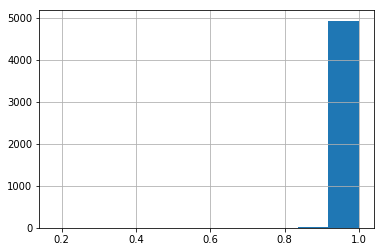

In [191]:
doc_pairs["cosine"].hist()

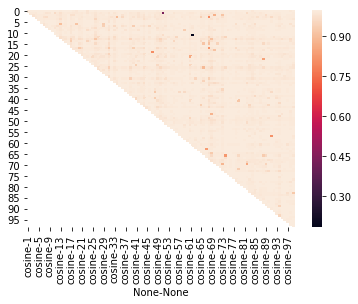

In [190]:
sns.heatmap(doc_pairs.unstack())
#Most of the books are quite similar 

In [205]:
with sqlite3.connect(db_name) as db:
    tfidf_small=pd.read_sql('SELECT * from tfidf_small',db,index_col=["bag_id","term_id"])

In [207]:
#unpack proper_noun_TFIDF
tfidf_small=tfidf_small.unstack()

In [208]:
tfidf_small.columns = tfidf_small.columns.droplevel(0)

In [210]:
labels=OHCO_T[OHCO_T.columns[2:4]].apply(lambda x: ' '.join(x.astype('str')),1).tolist()

In [211]:
SIMS = pdist(tfidf_small, metric='cosine')

In [215]:
doc_pairs_proper_noun=pd.DataFrame(columns=["cosine"],index=pd.MultiIndex.from_tuples(pair_idx))

In [216]:
doc_pairs_proper_noun["cosine"]=SIMS

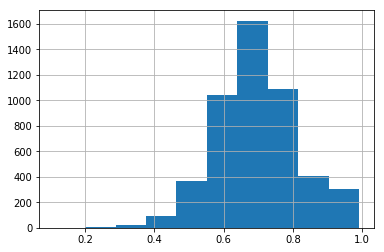

In [217]:
doc_pairs_proper_noun.cosine.hist()

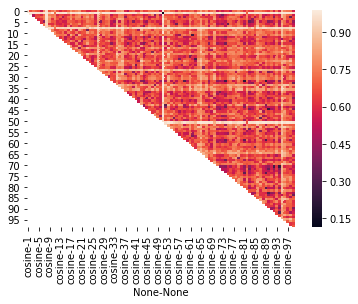

In [218]:
sns.heatmap(doc_pairs_proper_noun.unstack())
#Most of the books are quite similar 

In [212]:
TREE = sch.linkage(SIMS, method='ward')

### Plot hieararchical agglomerative clustering 

In [213]:
def plot_tree(tree, labels):
    plt.figure()
    fig, axes = plt.subplots(figsize=(10, 60))
    dendrogram = sch.dendrogram(tree, labels=labels, orientation="left")
    plt.tick_params(axis='both', which='major', labelsize=10)

<Figure size 432x288 with 0 Axes>

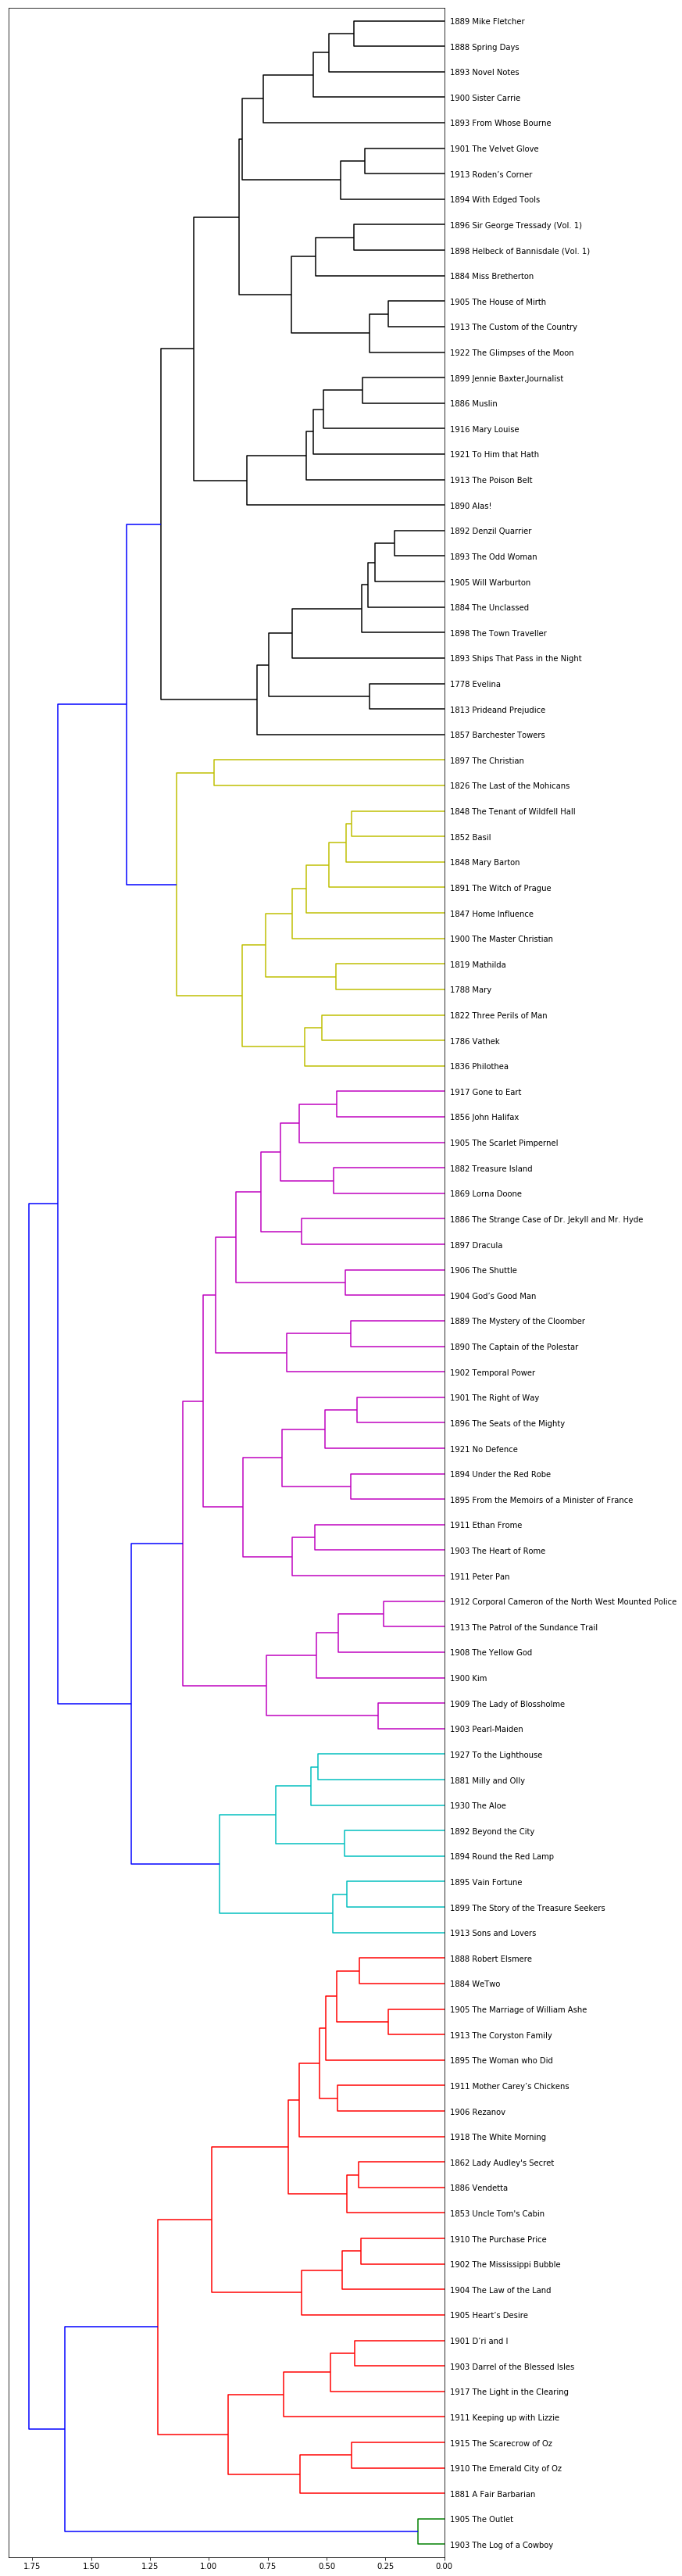

In [214]:
plot_tree(TREE, labels)

##### The above expriments of doc_pairs using entire TFIDF table and small proper noun TFIDF table, demonstrating that the importance of POS tag.

### PCA Analysis Using Proper Noun TFIDF

In [221]:
n_components = 10

In [222]:
pca = PCA(n_components=n_components)
projected = pca.fit_transform(tfidf_small)

#### Plot PCA Using Author

In [235]:
authors = T["author"]
aut_lets = list(set(authors))
author_ids = [aut_lets.index(x) for x in authors]

def plot_pca_author(proj, pc_a=0, pc_b=1):
    plt.figure(figsize=(5,5))
    plt.scatter(proj[:, pc_a], 
                proj[:, pc_b],
                c=author_ids, 
                edgecolor='none', alpha=0.5,
                cmap=plt.cm.get_cmap('Reds', 10))
    plt.xlabel('PC{}'.format(pc_a))
    plt.ylabel('PC{}'.format(pc_b))
    for i, x in enumerate(proj):
        plt.annotate(T["author"][i], (x[pc_a], x[pc_b]))
    plt.title("100 Novels PCA by Author")

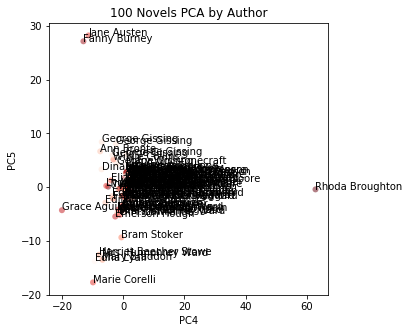

In [240]:
plot_pca_author(projected,4,5)  
#Using different components resulting in different results


#### Plot PCA Using Gender

In [243]:
#Plot PCA using country and gender 
genders = T["gender_x"]
letters = list(set(genders))
gender_ids = [letters.index(x) for x in genders]

def plot_pca_gender(proj, pc_a=0, pc_b=1):
    plt.figure(figsize=(5,5))
    plt.scatter(proj[:, pc_a], 
                proj[:, pc_b],
                c=gender_ids, 
                edgecolor='none', alpha=0.5,
                cmap=plt.cm.get_cmap('Reds', 10))
    plt.xlabel('PC{}'.format(pc_a))
    plt.ylabel('PC{}'.format(pc_b))
    for i, x in enumerate(proj):
        plt.annotate(T["gender_x"][i], (x[pc_a], x[pc_b]))
    plt.title("100 Books PCA by Gender")

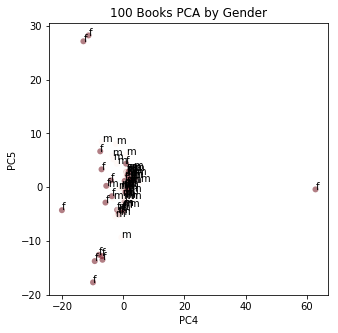

In [245]:
plot_pca_gender(projected,4,5)  
#Same Components,gender shows a clearer trends. 

### Analyze Sentiment of Books

In [259]:
books=T["text"]

In [262]:
### Preprocess Books 
books=books.apply(lambda x: x.strip())
books=books.apply(lambda x: x.replace('\n',' ').replace('\r',''))
books=books.apply(lambda x: x.strip())
books=books.apply(lambda x: x.lower())                  

In [266]:
books=books.apply(lambda x: re.sub(' +',' ',x))

In [276]:
senti_result=genearte_book_sentiment(books)
senti_result["Positive"]=senti_result["Positive"].apply(lambda x: int(x.split('.')[0]))
senti_result["Negative"]=senti_result["Negative"].apply(lambda x: int(x.split('.')[0]))
senti_result["Neutral"]=senti_result["Neutral"].apply(lambda x: int(x.split('.')[0]))

### Save Data (Sentiment of Each Book)

In [283]:
with sqlite3.connect(db_file) as db:
    senti_result.to_sql('sentiment', db, if_exists='replace', index=True)

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/pandas/core/generic.py:2130: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype)


In [286]:
T.head(1)

,filename,date,gender,author,nationality,title,words,text
0,1903 the heart of rome.txt,1903,m,Francis Marion Crawford,a,The Heart of Rome,99632.0,\n\n\n\nTHE HEART OF ROME\n\n\n\n\n\n\nCHAPTER...


In [287]:
T["book_num"]=T.index.tolist()

In [289]:
senti_df=senti_result.merge(T[["date","gender","author","nationality","title","words","book_num"]],how="left",on="book_num")

## Sentiment Changes Over Year

Text(0.5,1,'Sentiment Changes by Time')

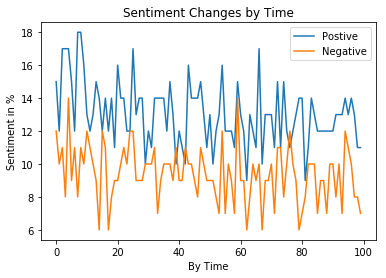

In [290]:
fig,ax=plt.subplots()
senti_df.sort_values(by="date").reset_index().Positive.plot(kind="line",ax=ax)
senti_df.sort_values(by="date").reset_index().Negative.plot(kind="line",ax=ax)
ax.legend(["Postive","Negative"])
ax.set_xlabel("By Time")
ax.set_ylabel("Sentiment in %")
ax.set_title("Sentiment Changes by Time")

#### Sentiment by Nationality 

[Text(0,0,'American'), Text(0,0,'British'), Text(0,0,'Canadian')]

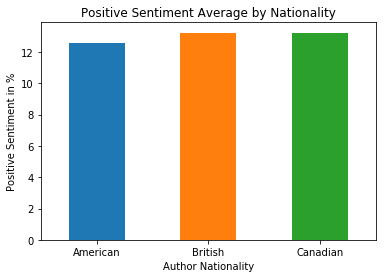

In [291]:

fig,ax=plt.subplots()
senti_df.groupby("nationality").Positive.mean().plot(kind="bar",ax=ax)
ax.set_xlabel("Author Nationality")
ax.set_ylabel("Positive Sentiment in %")
ax.set_title("Positive Sentiment Average by Nationality")
ax.set_xticklabels(labels=["American","British","Canadian"],rotation=360)


[Text(0,0,'American'), Text(0,0,'British'), Text(0,0,'Canadian')]

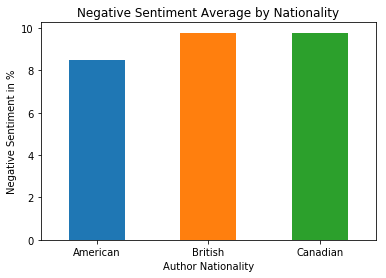

In [292]:

fig,ax=plt.subplots()
senti_df.groupby("nationality").Negative.mean().plot(kind="bar",ax=ax)
ax.set_xlabel("Author Nationality")
ax.set_ylabel("Negative Sentiment in %")
ax.set_title("Negative Sentiment Average by Nationality")
ax.set_xticklabels(labels=["American","British","Canadian"],rotation=360)


[Text(0,0,'American'), Text(0,0,'British'), Text(0,0,'Canadian')]

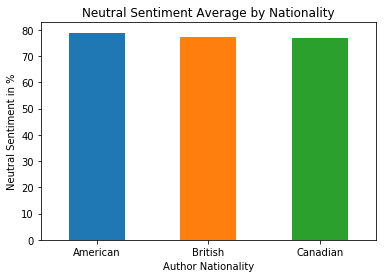

In [293]:

fig,ax=plt.subplots()
senti_df.groupby("nationality").Neutral.mean().plot(kind="bar",ax=ax)
ax.set_xlabel("Author Nationality")
ax.set_ylabel("Neutral Sentiment in %")
ax.set_title("Neutral Sentiment Average by Nationality")
ax.set_xticklabels(labels=["American","British","Canadian"],rotation=360)


#### Sentiment By Author Gender 

[Text(0,0,'Female'), Text(0,0,'Male')]

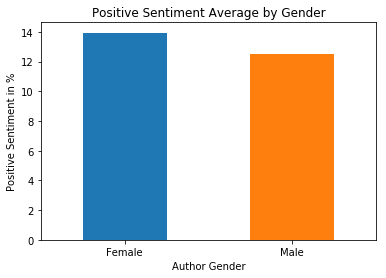

In [294]:
fig,ax=plt.subplots()
senti_df.groupby("gender").Positive.mean().plot(kind="bar",ax=ax)
ax.set_xlabel("Author Gender")
ax.set_ylabel("Positive Sentiment in %")
ax.set_title("Positive Sentiment Average by Gender")
ax.set_xticklabels(labels=["Female","Male"],rotation=360)

[Text(0,0,'Female'), Text(0,0,'Male')]

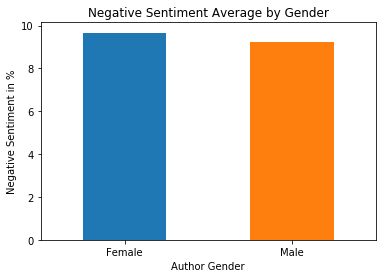

In [295]:
fig,ax=plt.subplots()
senti_df.groupby("gender").Negative.mean().plot(kind="bar",ax=ax)
ax.set_xlabel("Author Gender")
ax.set_ylabel("Negative Sentiment in %")
ax.set_title("Negative Sentiment Average by Gender")
ax.set_xticklabels(labels=["Female","Male"],rotation=360)

[Text(0,0,'Female'), Text(0,0,'Male')]

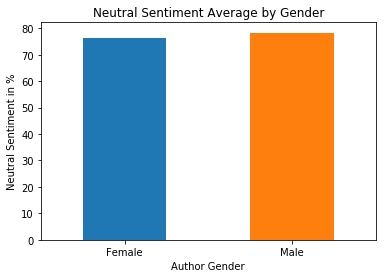

In [296]:
fig,ax=plt.subplots()
senti_df.groupby("gender").Neutral.mean().plot(kind="bar",ax=ax)
ax.set_xlabel("Author Gender")
ax.set_ylabel("Neutral Sentiment in %")
ax.set_title("Neutral Sentiment Average by Gender")
ax.set_xticklabels(labels=["Female","Male"],rotation=360)